
This notebook uses the output of the rule
--- 75_eval_contig_align.smk::summarize_contig_alignments
as input, and produces a multi-panel figure for the
purpose of QC

Execution directory:  /home/local/work/code/github/project-male-assembly/notebooks/plotting/ctgaln_qc
Working directory:  /home/local/work/data/sig_chrY/paper/ctg_aln
Output directory:  /home/local/work/data/sig_chrY/paper/output/figures


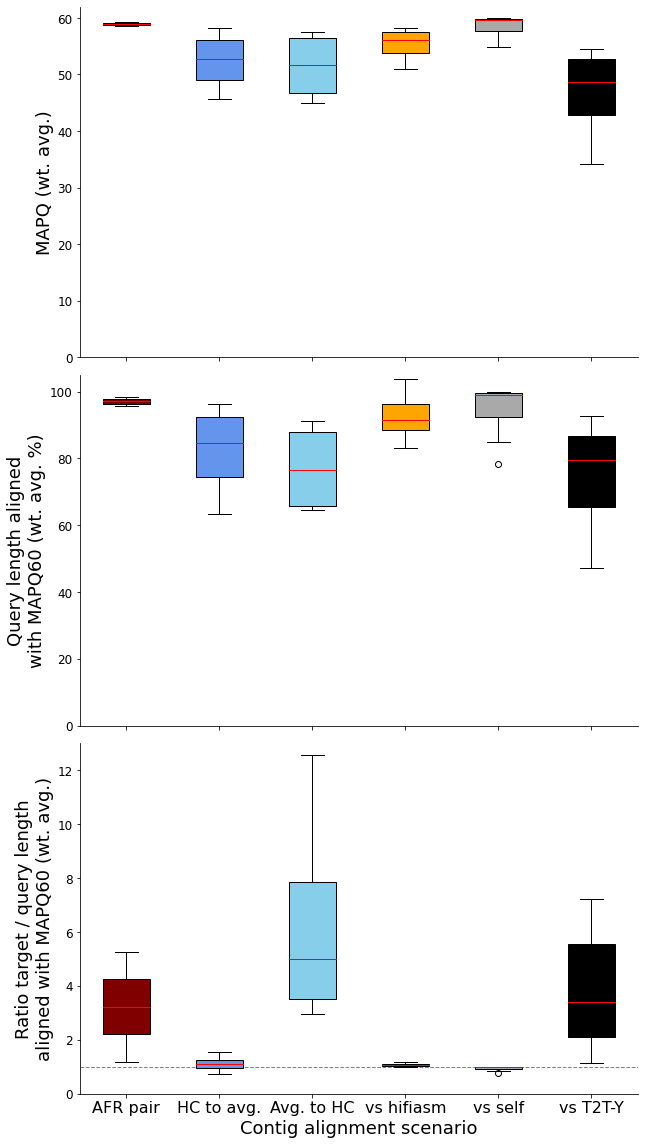

In [1]:
import pandas as pd
import numpy as np
import pathlib as pl
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt

desc="""
This notebook uses the output of the rule
--- 75_eval_contig_align.smk::summarize_contig_alignments
as input, and produces a multi-panel figure for the
purpose of QC
"""

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

print(desc)

save_plots = True

repo_dir = pl.Path('/home/local/work/code/github/project-male-assembly').resolve(strict=True)
exec_dir = pl.Path('.').resolve(strict=True)
wd_dir = pl.Path('/home/local/work/data/sig_chrY/paper/ctg_aln')
out_dir = pl.Path('/home/local/work/data/sig_chrY/paper/output/figures').resolve(strict=True)

print('Execution directory: ', exec_dir)
print('Working directory: ', wd_dir)
print('Output directory: ', out_dir)
print('=================================')

hc_samples = ['HC01457', 'HC02666', 'HC18989', 'HC19384', 'HG00358', 'HG01890', 'NA19317', 'NA19347']
afr_pair = ['NA19317', 'NA19347']
cov_pairs_to_hc = ['HC01457', 'HC02666', 'HC18989', 'HC19384']
cov_pairs_to_avg = ['HG01457', 'HG02666', 'NA18989', 'NA19384']
to_ref = ['T2TXY']

data = []
for table in wd_dir.glob('*.tsv'):
    df = pd.read_csv(table, sep='\t', header=0)
    sample, target = df.loc[df.index[0], ['sample', 'target']].values
    wtavg_mapq = df.loc[df['statistic'] == 'wtavg_mapq', 'value'].values[0]
    data.append((sample, target, 'wtavg_mapq', wtavg_mapq))
    
    wt_qalign_pct = np.average(
        df.loc[df['statistic'] == 'query_aligned_pct', 'value'],
        weights=df.loc[df['statistic'] == 'query_size', 'value'],
    )
    data.append((sample, target, 'wtavg_qalign_pct', wt_qalign_pct))
    
    wt_aln_spread = np.average(
        df.loc[df['statistic'] == 'alignment_spread', 'value'],
        weights=df.loc[df['statistic'] == 'query_size', 'value'],
    )
    data.append((sample, target, 'wtavg_aln_spread', wt_aln_spread))

    
data = pd.DataFrame.from_records(
    data,
    columns=['sample', 'target', 'statistic', 'value']
)

statistics = [
    ('MAPQ (wt. avg.)', 'wtavg_mapq', 'box', (0, 62)),
    ('Query length aligned\nwith MAPQ60 (wt. avg. %)', 'wtavg_qalign_pct', 'box', (0, 105)),
    ('Ratio target / query length\naligned with MAPQ60 (wt. avg.)', 'wtavg_aln_spread', 'box', (0, 13))
]

groups = [
    ('AFR pair', afr_pair, afr_pair, 'maroon'),
    ('HC to avg.', cov_pairs_to_hc, cov_pairs_to_avg, 'cornflowerblue'),
    ('Avg. to HC', cov_pairs_to_avg, cov_pairs_to_hc, 'skyblue'),
    ('vs hifiasm', hc_samples, ['hifiasm'], 'orange'),
    ('vs self', hc_samples, hc_samples, 'darkgrey'),
    ('vs T2T-Y', hc_samples, to_ref, 'black'),
]

fig, axes = plt.subplots(figsize=(10, 20), nrows=len(statistics), sharex=True, sharey=False)
fig_name = 'contig_align_QC'

for axrow, (stat_label, stat_select, plot_type, stat_range) in enumerate(statistics, start=0):
    sub_stats = data.loc[data['statistic'] == stat_select, :]
    group_data = []
    group_data_pos = []
    group_labels = []
    for pos, (group_label, select_samples, select_targets, group_color) in enumerate(groups, start=1):
        select_samples = sub_stats['sample'].isin(select_samples)
        select_targets = sub_stats['target'].isin(select_targets)
        selector = select_samples & select_targets
        if group_label != 'vs self':
            select_not_self = sub_stats['sample'] != sub_stats['target']
            selector &= select_not_self
        else:
            select_self = sub_stats['sample'] == sub_stats['target']
            selector &= select_self
        
        sub_data = sub_stats.loc[selector, 'value']
        #if 'spread' in stat_label and 'T2T' in group_label:
        #    continue
        group_data.append(sub_data.values)
        group_data_pos.append(pos)
    ax = axes[axrow]
    bx = ax.boxplot(
        group_data,
        positions=group_data_pos,
        patch_artist=True,
        medianprops={'color': 'red'}
    )
    ax.set_ylim(stat_range)
    for patch, color in zip(bx['boxes'], [t[3] for t in groups[:len(group_data)]]):
        patch.set_facecolor(color)
    ax.set_ylabel(stat_label, fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if axrow == 2:
        ax.set_xticks(np.arange(1, 7))
        ax.set_xticklabels([t[0] for t in groups], fontsize=16)
        ax.set_xlabel('Contig alignment scenario', fontsize=18)
        ax.axhline(1, 0, 1, ls='dashed', lw=1, zorder=0, c='grey')
    ax.tick_params(axis='y', which='major', labelsize=12)

plt.subplots_adjust(wspace=0., hspace=0.05)

if save_plots:
    plt.savefig(
        out_dir / pl.Path(f'{fig_name}.png'),
        dpi=150,
        bbox_inches='tight',
        transparent=None,
        facecolor="w"
    )
    plt.savefig(
        out_dir / pl.Path(f'{fig_name}.pdf'),
        bbox_inches='tight',
        transparent=None,
        facecolor="w"
    )

